# STELAR Pilot 2: Early Crop Growth Prediction - Midterm Demo

This document presents a demo pipeline for STELAR Pilot 2, focusing on early crop growth prediction. The pipeline incorporates various software modules developed as part of use case B.1 and B.2. These modules include:

1. Field Segmentation: This module is responsible for segmenting the agricultural fields from satellite imagery.
2. Data Fusion: The data fusion module combines multiple data sources, such as weather data, soil data, and satellite imagery, to provide a comprehensive dataset for analysis.
3. Time Series Extraction: This module extracts time series data from the fused dataset, capturing the development of relevant crop features over time.
4. Time Series Imputation: The time series imputation module fills in missing values in the extracted time series, ensuring a complete dataset for analysis.
5. Crop Classification: This module classifies the crops based on the extracted time series data, enabling the identification of different crop types.
6. Growth Prediction: The growth prediction module utilizes machine learning algorithms to predict the future growth of crops based on historical data.

By following this demo pipeline, users can gain insights into the early growth prediction of crops, which can be valuable for optimizing agricultural practices, and improving crop yield.

Please note that this document serves as a guide and demonstration of the STELAR Pilot 2 pipeline. It showcases the software modules developed for this use case and provides an overview of their functionalities. 
The actual implementation and deployment of the pipeline may require additional considerations, such as data preprocessing, model tuning, and deployment infrastructure.

## Pipeline Input

The pipeline takes the following inputs:
- Satellite Imagery in RAS format containing RGB and NIR reflectance data, as well as Leaf Area Index (LAI) statistics for each pixel.

In this demo, we will consider a **11,280m by 11,280m area** in the south of **France, near Bordeaux**. 
The area is dominated by agricultural land use and forests in the south-western parts.
The satellite imagery is obtained from the Sentinel-2 satellite, which provides multispectral data at a spatial resolution of 10m. 
We consider data gathered over **2020**, resulting in a stack of 87 images. 

In [4]:
import matplotlib.pyplot as plt
import stelar_spatiotemporal.lib as stlib
import os
import numpy as np

MINIO_ACCESS_KEY = 'minioadmin'
MINIO_SECRET_KEY = 'minioadmin'
MINIO_ENDPOINT_URL = 'http://localhost:9000'

os.environ["MINIO_ACCESS_KEY"] = MINIO_ACCESS_KEY
os.environ["MINIO_SECRET_KEY"] = MINIO_SECRET_KEY
os.environ["MINIO_ENDPOINT_URL"] = MINIO_ENDPOINT_URL

DEMO_BUCKET = "s3://stelar-spatiotemporal"

In [25]:
from stelar_spatiotemporal.preprocessing.vista_preprocessing import unpack_vista_unzipped, unpack_vista_reflectance
from stelar_spatiotemporal.segmentation.bands_data_package import BandsDataPackage

# Load and show the LAI and RGB data
LAI_PATH = f"{DEMO_BUCKET}/LAI_small/30TYQ_LAI_2020_small"
RGB_PATH = f"{DEMO_BUCKET}/RGB_small"

fs = stlib.get_filesystem(LAI_PATH)

# Unpack the LAI data to a temporary directory
unpack_vista_unzipped(ras_path=LAI_PATH + ".RAS", rhd_path=LAI_PATH + ".RHD", outdir="/tmp/lai")

rgb_bands_package = BandsDataPackage(b2_path=RGB_PATH + "/B2",
                                     b3_path=RGB_PATH + "/B3",
                                     b4_path=RGB_PATH + "/B4",
                                     b8_path=RGB_PATH + "/B8",
                                     file_extension='RAS')

# Unpack the RGBNIR data to a temporary directory
unpack_vista_reflectance(rgb_bands_package, outdir='/tmp/rgb')

Unpacking 87 images from s3://stelar-spatiotemporal/LAI_small/30TYQ_LAI_2020_small.RAS
Unpacking s3://stelar-spatiotemporal/RGB_small/B2/30TYQ_B2_2020.RAS into /tmp/rgb/B2
Unpacking 87 images from s3://stelar-spatiotemporal/RGB_small/B2/30TYQ_B2_2020.RAS
Unpacking s3://stelar-spatiotemporal/RGB_small/B3/30TYQ_B3_2020.RAS into /tmp/rgb/B3
Unpacking 87 images from s3://stelar-spatiotemporal/RGB_small/B3/30TYQ_B3_2020.RAS
Unpacking s3://stelar-spatiotemporal/RGB_small/B4/30TYQ_B4_2020.RAS into /tmp/rgb/B4
Unpacking 87 images from s3://stelar-spatiotemporal/RGB_small/B4/30TYQ_B4_2020.RAS
Unpacking s3://stelar-spatiotemporal/RGB_small/B8/30TYQ_B8A_2020.RAS into /tmp/rgb/B8A
Unpacking 87 images from s3://stelar-spatiotemporal/RGB_small/B8/30TYQ_B8A_2020.RAS


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


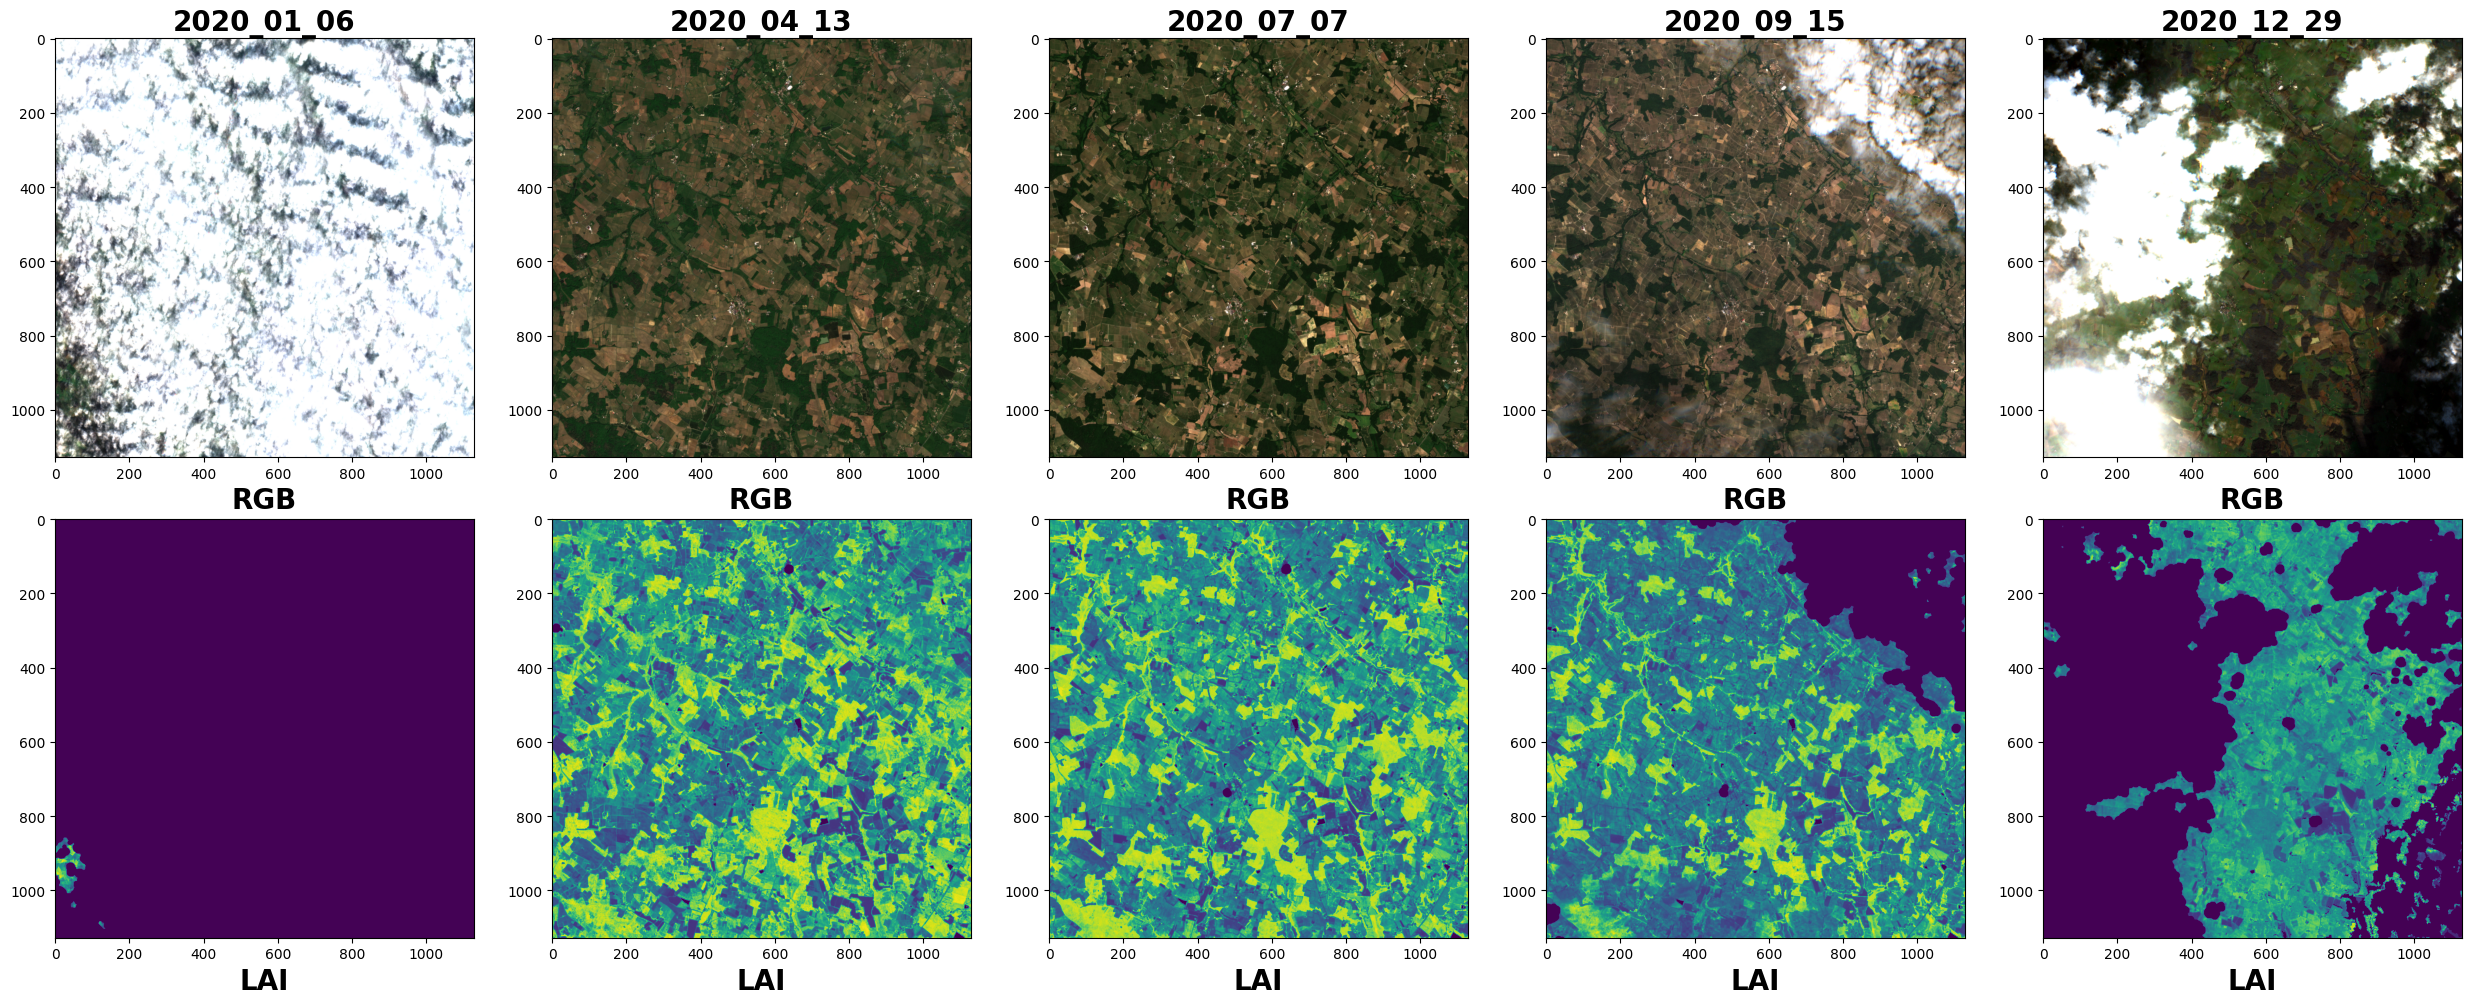

In [26]:
import glob
import numpy as np 

npy_files = sorted([p for p in os.listdir("/tmp/lai") if p.endswith(".npy")])

# Plot multiple lai and rgb files
ncols = 5
ids = np.linspace(0, len(npy_files)-1, ncols, dtype=int)

fig, axs = plt.subplots(2, ncols, figsize=(5*ncols, 5*2))

for i,idx in enumerate(ids):
    rax = axs[0,i]
    lax = axs[1,i]

    rax.set_title(npy_files[idx].replace(".npy", ""), fontsize=20, fontweight='bold')

    lai = np.load(f"/tmp/lai/{npy_files[idx]}")
    b2 = np.load(f"/tmp/rgb/B2/{npy_files[idx]}")
    b3 = np.load(f"/tmp/rgb/B3/{npy_files[idx]}")
    b4 = np.load(f"/tmp/rgb/B4/{npy_files[idx]}")
    rgb = np.stack([b4, b3, b2], axis=-1)

    # Plot the RGB image
    rax.imshow(rgb / 10000 * 3.5)

    # Plot the LAI image
    lax.imshow(lai, cmap='viridis')

    rax.set_xlabel("RGB", fontsize=20, fontweight='bold')
    lax.set_xlabel("LAI", fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()

## Data Fusion

## Field segmentation

The field segmentation module is responsible for identifying and segmenting the agricultural fields from the satellite imagery. This is achieved using a ResUNet model, which is trained to recognize the boundaries of fields and distinguish them from other land cover types.

Input:
- RGB-NIR Satellite Imagery in RAS format
- Model weights for ResUNet

Output:
- A shapefile containing the fields

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '2020_07_27')

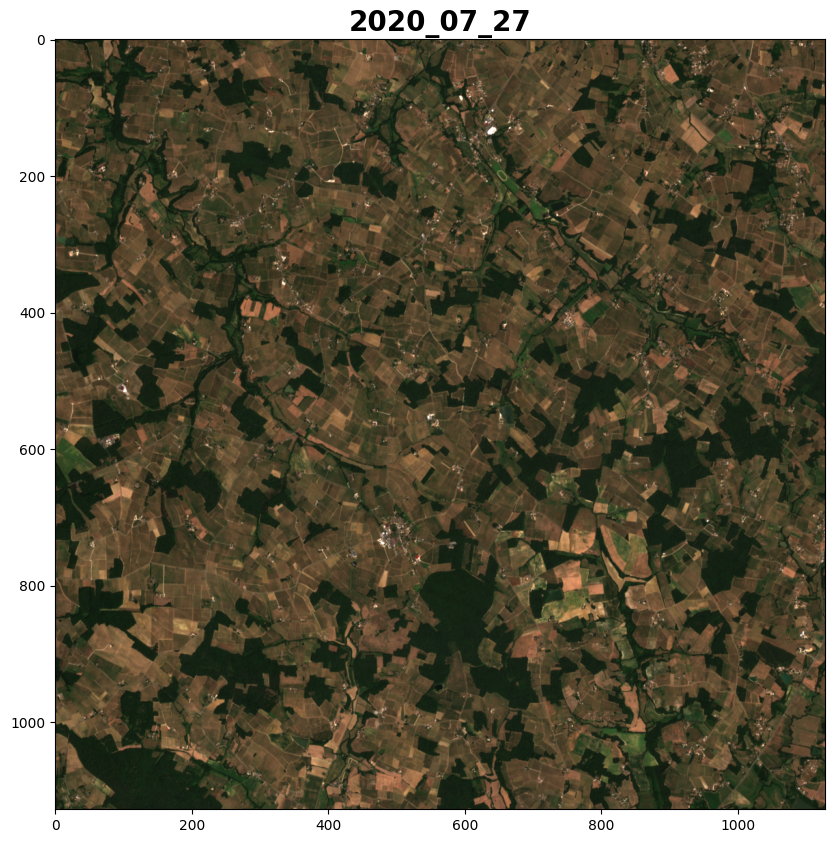

In [45]:
# Plot the image we're going to use

fig,ax = plt.subplots(1,1, figsize=(10,10))

sdate = "2020_07_27"

npy_file = sdate + ".npy"

b2 = np.load(f"/tmp/rgb/B2/{npy_file}")
b3 = np.load(f"/tmp/rgb/B3/{npy_file}")
b4 = np.load(f"/tmp/rgb/B4/{npy_file}")
rgb = np.stack([b4, b3, b2], axis=-1)

ax.imshow(rgb / 10000 * 3.5)

ax.set_title(sdate, fontsize=20, fontweight='bold')

In [67]:
# Run field segmentation docker
! docker pull alexdarancio7/stelar_field_segmentation:latest

b2_path = f"{RGB_PATH}/B2"
b3_path = f"{RGB_PATH}/B3"
b4_path = f"{RGB_PATH}/B4"
b8_path = f"{RGB_PATH}/B8"

fields_out_path = f"{DEMO_BUCKET}/fields_2020_07_27.gpkg"
model_path = f"{DEMO_BUCKET}/resunet-a_fold-0_2023-03-27-09-29-38"
sdates = sdate.replace("_", "-")

! docker run -it \
--network="host" \
alexdarancio7/stelar_field_segmentation \
-b2 {b2_path} \
-b3 {b3_path} \
-b4 {b4_path} \
-b8 {b8_path} \
-o {out_path} \
-m {model_path} \
-s {sdates} \
--MINIO_ACCESS_KEY {MINIO_ACCESS_KEY} \
--MINIO_SECRET_KEY {MINIO_SECRET_KEY} \
--MINIO_ENDPOINT_URL {MINIO_ENDPOINT_URL}


latest: Pulling from alexdarancio7/stelar_field_segmentation
Digest: sha256:7a2a2d0c29a231568c96ee87839242a2cfa3556813b67c4d3d5740b366de88cb
Status: Image is up to date for alexdarancio7/stelar_field_segmentation:latest
docker.io/alexdarancio7/stelar_field_segmentation:latest
2024-03-14 12:53:35.928804: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/site-packages/cv2/../../lib64:
2024-03-14 12:53:35.928823: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/local/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:205: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
/usr/local/lib/python3.9/site-packages/tensorboard/compat/

In [53]:
# Get the fields
from stelar_spatiotemporal.preprocessing.timeseries import load_fields

gdf = load_fields(out_path, min_area=5000)

minx, miny, maxx, maxy = gdf.total_bounds

gdf

geometry
0     POLYGON ((747172.990 4954956.250, 747173.750 4...
1     POLYGON ((750849.950 4954956.250, 750851.250 4...
2     POLYGON ((753834.675 4954951.250, 753836.250 4...
3     POLYGON ((753426.421 4954941.250, 753428.750 4...
4     POLYGON ((746144.950 4954928.750, 746146.250 4...
...                                                 ...
1600  POLYGON ((756253.750 4943745.000, 756252.500 4...
1601  POLYGON ((749076.490 4946063.750, 749076.250 4...
1602  POLYGON ((751476.450 4945818.750, 751476.250 4...
1603  POLYGON ((745609.950 4944081.250, 745608.750 4...
1604  POLYGON ((748088.425 4945561.250, 748086.250 4...

[1605 rows x 1 columns]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


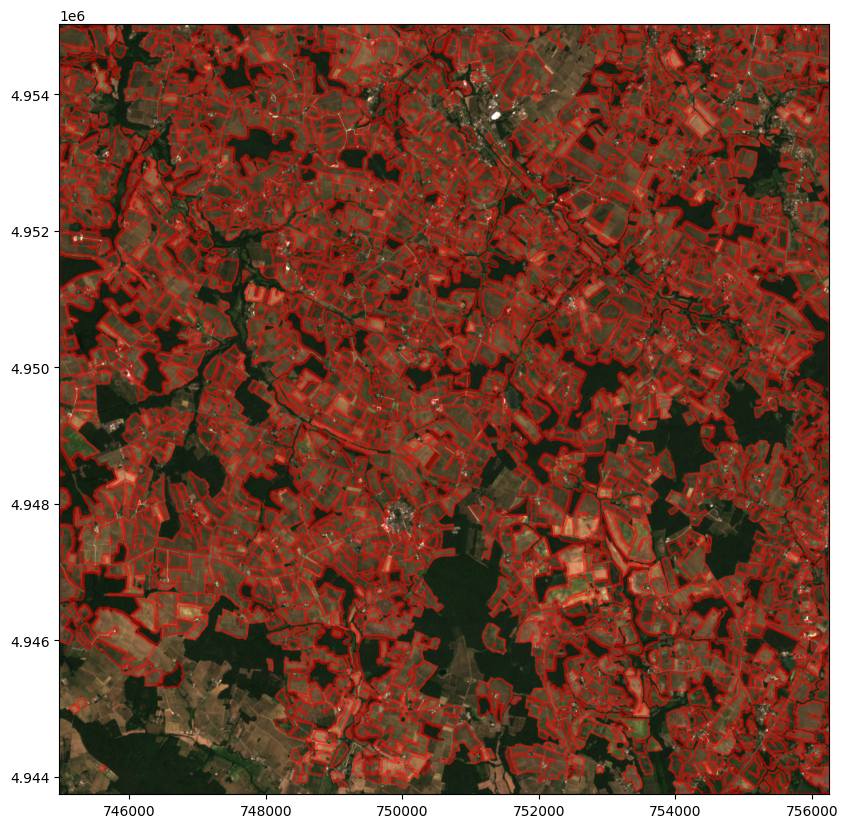

In [54]:
# Show the fields

fig,ax = plt.subplots(1,1, figsize=(10,10))

gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1.5, alpha=0.5, zorder=2)

ax.imshow(rgb / 10000 * 3.5, zorder=1, extent=[minx, maxx, miny, maxy])

plt.show()

## Time Series Extraction

The time series extraction module is responsible for extracting time series data from the fused dataset, capturing the development of relevant crop features over time. This module utilizes the field segmentation results to extract time series data for each field. It does not require a field shapefile though, as it can also extract time series data on a pixel level.

Input:
- A raster of land statistics (e.g. LAI) in RAS format.
- (Optional) A shapefile containing boundaries of areas of interest (e.g. fields)

Output:
- A time series dataset containing the land statistics for each field and/or pixel over time.

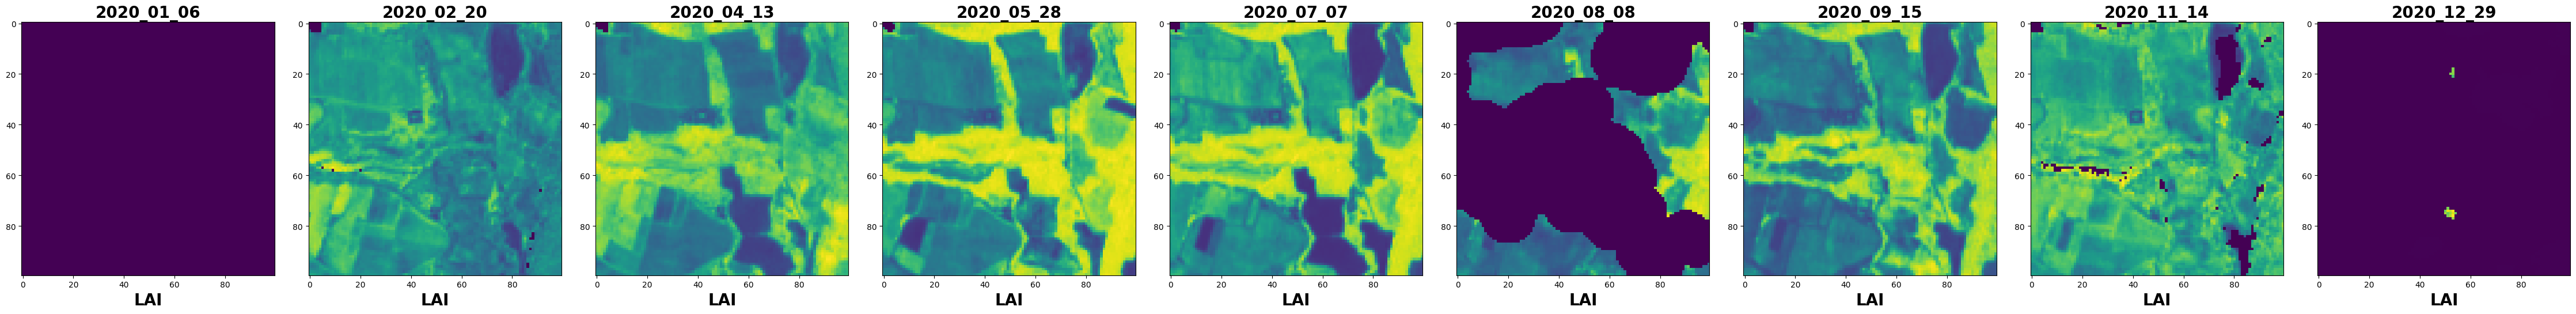

In [64]:
# Plot the input data

ncols = 9
ids = np.linspace(0, len(npy_files)-1, ncols, dtype=int)

slc = slice(0,100)

fig, axs = plt.subplots(1, ncols, figsize=(5*ncols, 5))

for i,idx in enumerate(ids):
    ax = axs[i]

    ax.set_title(npy_files[idx].replace(".npy", ""), fontsize=20, fontweight='bold')

    lai = np.load(f"/tmp/lai/{npy_files[idx]}")[slc,slc]

    # Plot the LAI image
    ax.imshow(lai, cmap='viridis')

    ax.set_xlabel("LAI", fontsize=20, fontweight='bold')

plt.tight_layout()
plt.show()

In [69]:
# Run time series extraction docker
! docker pull alexdarancio7/stelar_image2ts:latest

input_path = f"{DEMO_BUCKET}/LAI_small"
ts_out_path = f"{DEMO_BUCKET}"

! docker run -it \
--network="host" \
alexdarancio7/stelar_image2ts \
-i {input_path} \
-o {ts_out_path} \
-f {fields_out_path} \
--MINIO_ACCESS_KEY {MINIO_ACCESS_KEY} \
--MINIO_SECRET_KEY {MINIO_SECRET_KEY} \
--MINIO_ENDPOINT_URL {MINIO_ENDPOINT_URL}

latest: Pulling from alexdarancio7/stelar_image2ts
Digest: sha256:07182c995db0e3fe262160adb247d776565df804c56fc939f1f0d8358c465b50
Status: Image is up to date for alexdarancio7/stelar_image2ts:latest
docker.io/alexdarancio7/stelar_image2ts:latest
1. Unpacking RAS files...
Unpacking 87 images from s3://stelar-spatiotemporal/LAI_small/30TYQ_LAI_2020_small.RAS
2. Combining the images into eopatches...
Processing 1 partitions of 87 dates each
3. Creating pixel-level time series...
3. Extracting timeseries per patchlet: 100%|██████| 1/1 [00:42<00:00, 42.84s/it]
4. Creating field-level time series...
Processing eopatch 1/1
1. Temporarily saving eopatch as tiff
Time taken: 16.524036645889282 seconds
2. Masking tiff and saving timeseries
100%|██████████████████████████████████████| 2145/2145 [00:18<00:00, 113.33it/s]
Time taken: 19.831480026245117 seconds
5. Cleaning up...
Deleting /tmp/npys
Deleting /tmp/lai_eopatch
Deleting /tmp/patchlets


In [5]:
import pandas as pd

# Download the files
pxts_path = f"{DEMO_BUCKET}/pixel_timeseries/patchlet_0_0.csv"
fts_path = f"{DEMO_BUCKET}/field_timeseries/lai_field_timeseries.csv"

tmp_pxts_path = "/tmp/patchlet_0_0.csv"
tmp_fts_path = "/tmp/lai_field_timeseries.csv"

fs = stlib.get_filesystem(fts_path)
fs.download(pxts_path, tmp_pxts_path)
fs.download(fts_path, tmp_fts_path)

# Print the shapes of the data
with open(tmp_pxts_path, 'r') as f:
    cols = f.readline().strip().split(",")
    print("Number of pixel time series:", len(cols))

with open(tmp_fts_path, 'r') as f:
    cols = f.readline().strip().split(",")
    print("Number of field time series:", len(cols))

Number of pixel time series: 1272385
Number of field time series: 2146


In [45]:
# Load the data
df_pxts = pd.read_csv(tmp_pxts_path, usecols=np.arange(14)).set_index("index").sort_index()
df_fts = pd.read_csv(tmp_fts_path).set_index("index")

df_pxts.index = pd.to_datetime(df_pxts.index)
df_fts.index = pd.to_datetime(df_fts.index)

df_pxts[df_pxts < 0] = np.nan

df_pxts.head()

0_0  1_0  2_0  3_0     4_0     5_0     6_0     7_0     8_0  \
index                                                                    
2020-01-06  NaN  NaN  NaN  NaN     NaN     NaN     NaN     NaN     NaN   
2020-01-11  NaN  NaN  NaN  NaN  1345.0  3399.0  3313.0  3418.0  3177.0   
2020-01-14  NaN  NaN  NaN  NaN  1251.0  3515.0  3485.0  3035.0  2713.0   
2020-01-16  NaN  NaN  NaN  NaN     NaN  3016.0  3518.0  3311.0  2898.0   
2020-01-19  NaN  NaN  NaN  NaN   948.0  3698.0  3674.0  3344.0  3010.0   

               9_0    10_0    11_0    12_0  
index                                       
2020-01-06     NaN     NaN     NaN     NaN  
2020-01-11  3070.0  2918.0  2796.0  2756.0  
2020-01-14  2696.0  2635.0  2771.0  2669.0  
2020-01-16  2814.0  2763.0  2655.0  2682.0  
2020-01-19  3033.0  2949.0  2986.0  2856.0

In [46]:
df_fts.head()

0       1       2       3       4       5       6       7  \
index                                                                        
2020-01-06     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2020-01-11  4268.0  2578.0  2642.0  3504.0  3536.0  3684.0  2072.0  3824.0   
2020-01-14  3780.0  2514.0  2568.0  3242.0  3472.0  3536.0  1865.0  3390.0   
2020-01-16  4176.0  2488.0  2470.0  3382.0  3588.0  3604.0  2060.0  3694.0   
2020-01-19  4344.0  2638.0  2744.0  3590.0  3916.0  3866.0  2064.0  3920.0   

                 8       9  ...    2135    2136    2137    2138    2139  \
index                       ...                                           
2020-01-06     NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN   
2020-01-11  2670.0  3340.0  ...  2386.0  2956.0  2610.0  1074.0  2914.0   
2020-01-14  2792.0  3218.0  ...  2376.0  2894.0  2640.0  1041.0  2864.0   
2020-01-16  2740.0  3202.0  ...  2312.0  2766.0  2588.0  1039.0  2856.0   
2020-01-19  3004.0  3516.0  ...  2640.0  3008.0  2860.0  1154.0  3064.0   

             2140    2141    2142   2143    2144  
index                                             
2020-01-06    NaN     NaN     NaN    NaN     NaN  
2020-01-11  863.0  2436.0  3144.0  361.0  2764.0  
2020-01-14  992.0  2420.0  3048.0  434.0  2700.0  
2020-01-16  843.0  2400.0  2926.0  362.0  2676.0  
2020-01-19  978.0  2704.0  3066.0  431.0  2892.0  

[5 rows x 2145 columns]

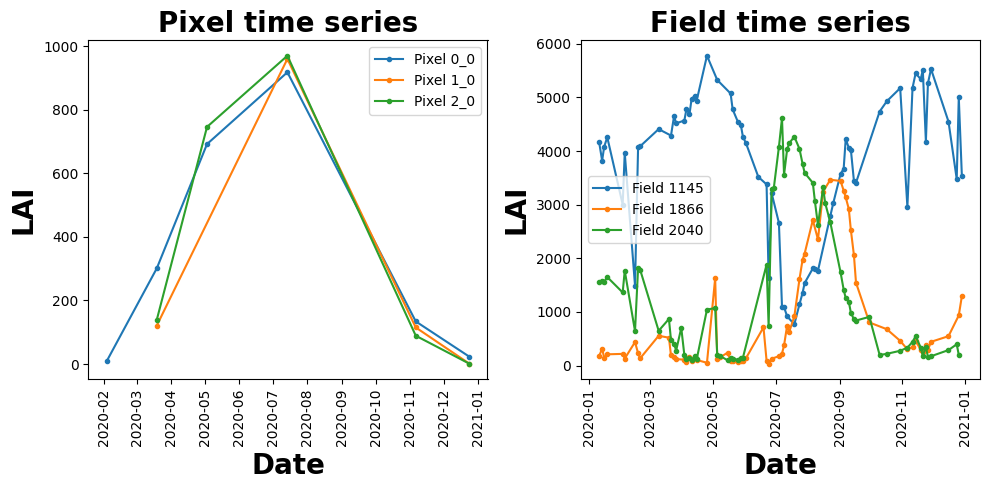

In [66]:
# Plot the data
import seaborn as sns

fig,axs = plt.subplots(1,2, figsize=(10,5))

nts = 3

# Plot nts random pixel time series and field time series
dts = df_pxts.index
pcols = df_pxts.columns
fcols = df_fts.columns

tids = np.linspace(0, len(dts)-1, 8, dtype=int)
# xticks = dts[tids]

# Plot the pixel time series
ax = axs[0]
ax.set_title("Pixel time series", fontsize=20, fontweight='bold')
ax.set_ylabel("LAI", fontsize=20, fontweight='bold')
ax.set_xlabel("Date", fontsize=20, fontweight='bold')

for i in range(nts):
    pid = pcols[i]

    # Get data that is non nan
    data = df_pxts[pid].dropna().sort_index()

    ax.plot(data, marker='.',label="Pixel " + pid)

ax.legend()

# Slightly rotate the xticks
for label in ax.get_xticklabels():
    label.set_rotation(90)

# Plot the field time series
ax = axs[1]
ax.set_title("Field time series", fontsize=20, fontweight='bold')
ax.set_ylabel("LAI", fontsize=20, fontweight='bold')
ax.set_xlabel("Date", fontsize=20, fontweight='bold')

for fid in np.array([1145,1866,2040]).astype(str):
    # Get data that is non nan
    data = df_fts[fid].dropna().sort_index()

    ax.plot(data, marker='.',label="Field " + fid)

ax.legend()

# Slightly rotate the xticks
for label in ax.get_xticklabels():
    label.set_rotation(90)

plt.tight_layout()
plt.show()

## Data imputation

## Crop Classification

#### Visualization of spation temporal input and outputs for crop type prediction models

In [1]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)

2024-06-25 20:15:53.755746: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-25 20:15:53.807754: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-25 20:15:54.721031: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1
3.3.3


In [2]:
#Make sure the GPU is available. 
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2024-06-25 20:15:56.898308: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-25 20:15:56.899698: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-25 20:15:56.944921: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
import segmentation_models_3D as sm
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Segmentation Models: using `tf.keras` framework.


In [4]:
def get_labels_in_color(groud_truth_image):
    color_map = {
        0: [0, 0, 0],1: [0, 255, 0], 2: [0, 0, 255], 3: [255, 255, 0], 4: [255, 165, 0], 5: [255, 0, 255], 6: [0, 255, 255],   
        7: [128, 0, 128], 8: [128, 128, 0], 9: [0, 128, 0], 10: [128, 0, 0], 11: [0, 0, 128], 12: [128, 128, 128], 13: [0, 128, 128],   
        14: [255, 0, 0], 15: [255, 255, 255], 16: [192, 192, 192], 17: [255, 0, 0], 18: [0, 255, 0], 19: [0, 0, 255], 20: [255, 255, 0],   
        21: [255, 165, 0], 22: [255, 0, 255],  23: [0, 255, 255],  24: [128, 0, 128],  25: [128, 128, 0],  26: [0, 128, 0],     
        27: [128, 0, 0],  28: [0, 0, 128], 29: [128, 128, 128], 30: [0, 128, 128], 31: [0, 0, 0], 32: [255, 255, 255], 
        33: [192, 192, 192], 34: [255, 0, 0], 35: [0, 255, 0], 36: [0, 0, 255], 37: [255, 255, 0], 38: [255, 165, 0], 
        39: [255, 0, 255],  40: [0, 128, 255] }
    groud_truth_color_image = np.zeros(groud_truth_image.shape + (3,), dtype=np.uint8)
    for i in range(groud_truth_image.shape[0]):
        for j in range(groud_truth_image.shape[1]):
            segment_id_gt = groud_truth_image[i, j]
            groud_truth_color_image[i, j] = color_map[segment_id_gt]
    return groud_truth_color_image

In [5]:
all_input_img = []
all_input_mask = []
for a in range(11):
    input_img = io.imread('/home/luser/stelar_3d/storage/train'+str(a)+'.tif')
    input_mask = io.imread('/home/luser/stelar_3d/storage/lab'+str(a)+'.tif').astype(np.uint8)
    all_input_img.append(input_img)
    all_input_mask.append(input_mask)

input_img = np.array(all_input_img).reshape(-1, 64, 64, 64)
input_mask = np.array(all_input_mask).reshape(-1, 64, 64)
#input_mask = np.repeat(input_mask[:, np.newaxis, :, :], repeats=64, axis=1)

print(input_img.shape)
print(input_mask.shape)

(704, 64, 64, 64)
(704, 64, 64)


In [7]:
# 3 good, 4 bit variety, 7 good
select_patch = 1
selected_patch = input_mask[select_patch,0,:,:]
labels_color = get_labels_in_color(selected_patch)
plt.figure(figsize=(6,6))
plt.title('Time series input')
plt.axis('off')
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(input_img[select_patch,i,:,:])
    plt.axis('off')
plt.show()
plt.subplot(1, 2, 2) 
plt.title('Expected output')
plt.axis('off')
plt.imshow(labels_color)
plt.axis('off')
plt.show()



IndexError: too many indices for array: array is 3-dimensional, but 4 were indexed

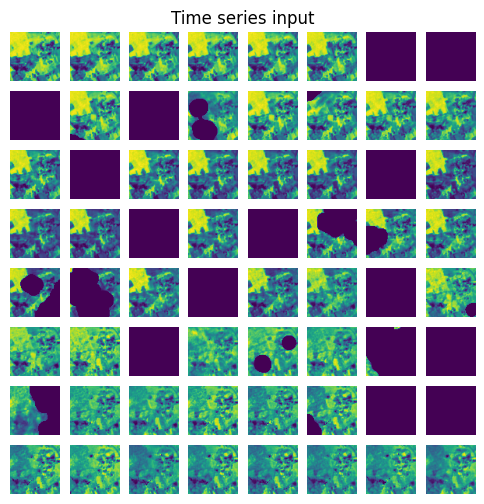

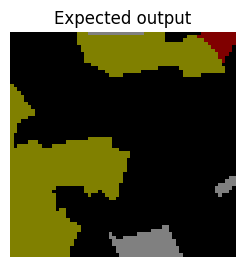

In [ ]:
# 3 good, 4 bit variety, 7 good
select_patch = 4
selected_patch = input_mask[select_patch,0,:,:]
labels_color = get_labels_in_color(selected_patch)
plt.figure(figsize=(6,6))
plt.title('Time series input')
plt.axis('off')
for i in range(64):
    plt.subplot(8, 8, i+1)
    plt.imshow(input_img[select_patch,i,:,:])
    plt.axis('off')
plt.show()
plt.subplot(1, 2, 2) 
plt.title('Expected output')
plt.axis('off')
plt.imshow(labels_color)
plt.axis('off')
plt.show()

